In [1]:
import pandas as pd
import numpy as dragon
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
from statsmodels.tsa.arima_model import ARIMA
import re

#importing packages for the prediction of time-series data
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

C:\Users\nishi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train=pd.read_excel('CropPricesComplete.xlsx')
crops=train['crop/commodity'].unique()
print(crops)

['Rice' 'Sesamum' 'Soyabean' 'Safflower' 'Mustard' 'Arhar Dal' 'Bajra'
 'Jowar' 'Maize' 'Wheat']


36
36
36
36
36
36
36
36
36
36


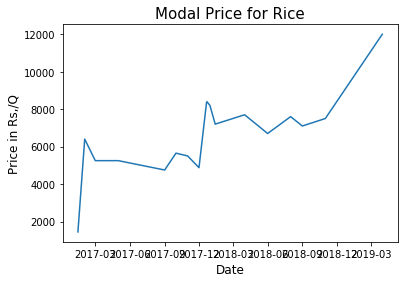

In [3]:
# print(train.isnull().count())
# Taking data where value is present removing NR in prices

for i in crops:    
    train=train[(train['Minimum Price(Rs./Quintal)']!="NR")]
    train=train[(train['Market']=="Akot")]
    train=train[(train['crop/commodity']=="Sesamum")]
    data = train['Modal Price(Rs./Quintal)']
    Date1 = train['Date']
    train1 = train[['Date','Modal Price(Rs./Quintal)']]
    print(train1.size)
    # print(train1.to_string())
    # Setting the Date as Index
    train2 = train1.set_index('Date')
    train2.sort_index(inplace=True)
# print (type(train2))
# print (train2.head())
plot.plot(train2)
plot.xlabel('Date', fontsize=12)
plot.ylabel('Price in Rs,/Q', fontsize=12)
plot.title("Modal Price for Rice", fontsize=15)
plot.show()

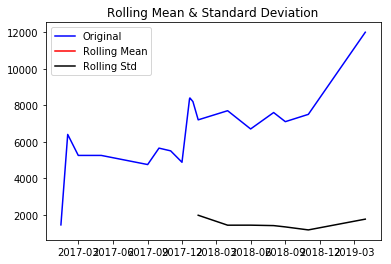

ADF Stastistic: 0.000000
p-value: 0.958532
The graph is non stationery
Critical values:
	1%: -4.473 
	5%: -3.290 
	10%: -2.772 


C:\Users\nishi\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [4]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):
    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plot.plot(x, color='blue',label='Original')
    mean = plot.plot(rolmean, color='red', label='Rolling Mean')
    std = plot.plot(rolstd, color='black', label = 'Rolling Std')
    plot.legend(loc='best')
    plot.title('Rolling Mean & Standard Deviation')
    plot.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
        
ts = train2['Modal Price(Rs./Quintal)']      
test_stationarity(ts)


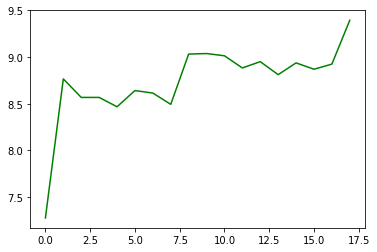

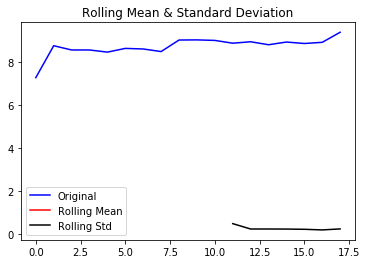

ADF Stastistic: 0.000000
p-value: 0.958532
The graph is non stationery
Critical values:
	1%: -4.473 
	5%: -3.290 
	10%: -2.772 


C:\Users\nishi\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [5]:
# print(type(ts))
ts_list=ts.tolist()
ts_log = dragon.log(ts_list)
# ts.apply(dragon.log)
plot.plot(ts_log,color="green")
plot.show()
# print(type(ts_log))
test_stationarity(pd.Series(ts_log))

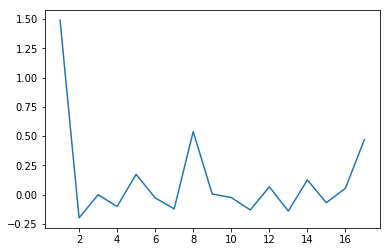

In [6]:
ts_log_diff = ts_log - pd.Series(ts_log).shift()
plot.plot(ts_log_diff)
plot.show()
# print(ts_log_diff)

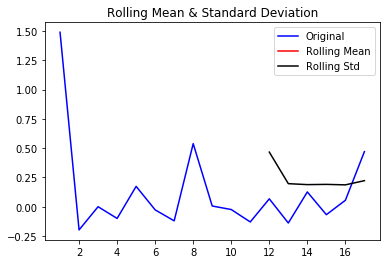

ADF Stastistic: 0.000000
p-value: 0.958532
The graph is non stationery
Critical values:
	1%: -4.665 
	5%: -3.367 
	10%: -2.803 


C:\Users\nishi\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [7]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)
# print(ts_log_diff)

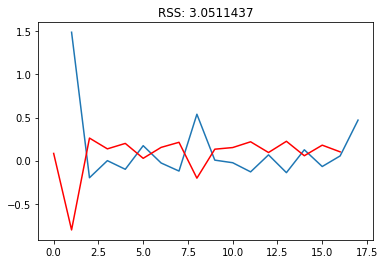

In [8]:
# follow lag
model = ARIMA(ts_log, order=(1,1,0))  
results_ARIMA = model.fit(disp=-1)  
plot.plot(ts_log_diff)
plot.plot(results_ARIMA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plot.show()

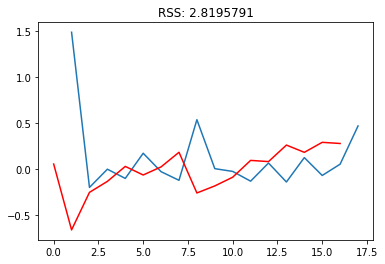

In [9]:
# follow error
model = ARIMA(ts_log, order=(0,1,1))  
results_MA = model.fit(disp=-1)  
plot.plot(ts_log_diff)
plot.plot(results_MA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plot.show()
# print(ts_log)

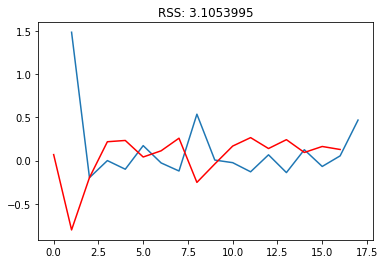

In [10]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2,1,0))  
results_ARIMA = model.fit(disp=-1)  
plot.plot(ts_log_diff)
plot.plot(results_ARIMA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plot.show()

In [11]:
size = int(len(ts_log)-100)
# Divide into train and test
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history,order=(2,1,0))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    pred_value = output[0]
    original_value = test_arima[t]
    history.append(original_value)
    pred_value = dragon.exp(pred_value)
    original_value = dragon.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
plot.figure(figsize=(8, 6))
test_day = [t
           for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plot.plot(test_day, predictions, color= 'green')
plot.plot(test_day, originals, color = 'orange')
plot.title('Expected Vs Predicted Views Forecasting')
plot.xlabel('Day')
plot.ylabel('Closing Price')
plot.legend(labels)
plot.show()

Printing Predicted vs Expected Values...




ValueError: Insufficient degrees of freedom to estimate

In [12]:
model = ARIMA(ts_log,order=(2,1,0))
model_fit = model.fit(disp=-1)

In [13]:
out=model_fit.forecast(steps=10)
for i in out[0]:
    print(dragon.exp(i))

9283.00510702
11356.2794212
12206.9097031
12475.6332529
13897.4276039
14668.812961
15716.7519072
16943.0288624
18079.4144459
19414.716666
